In [108]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.models import vgg16
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image

In [109]:
torch.has_mps

<ipython-input-109-9f62291be6af>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps


False

In [110]:
torch.cuda.is_available()

False

In [111]:
class MyCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=3)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, padding=1)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, padding=1)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv4 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0)
        self.linear1 = torch.nn.Linear(256, 64)
        self.linear2 = torch.nn.Linear(64, 16)
        self.linear3 = torch.nn.Linear(16, 3)
        # self.softmax = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.relu(x)
        x = self.conv4(x).squeeze(2).squeeze(2)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        # x = self.softmax(x)
        return x

In [112]:
model = MyCNN()

In [113]:
device = 'mps' if torch.has_mps else 'cpu'
model = model.to(device)

<ipython-input-113-c8a0c36c4d5b>:1: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = 'mps' if torch.has_mps else 'cpu'


In [114]:
my_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225)),
        transforms.RandomRotation((-10, 10)),
        transforms.RandomHorizontalFlip(p=0.5)
    ]
)
my_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(32),
        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                             std=(0.229, 0.224, 0.225))
    ]
)

In [115]:
train_dataset = ImageFolder(root='/content/drive/MyDrive/afhq/train', transform=my_transform_train)
test_dataset = ImageFolder(root='/content/drive/MyDrive/afhq/val', transform=my_transform_test)

In [116]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [117]:
model.forward(next(iter(train_dataloader))[0].to(device)).shape

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([256, 3])

In [118]:
num_epochs = 16
lr = 1e-3
optimizer = Adam(model.parameters(), lr=lr)
### Используем скедулер для уменьшения лернинг рейта
scheduler = ReduceLROnPlateau(optimizer=optimizer, factor=0.5, patience=2, threshold=1e-3)

In [119]:
def loss_function(preds, true):
    loss = nn.CrossEntropyLoss()
    return loss(preds, true)

In [120]:
all_train_losses = []
all_test_losses = []

loss train 0.9181564450263977
loss test 1.0030680894851685


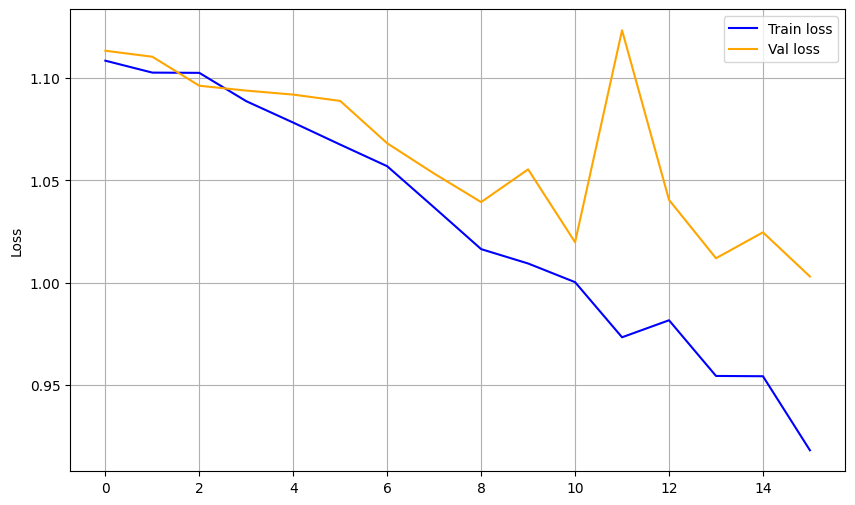

In [121]:
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    model.train(True)
    print(f'epoch_number is {epoch}. Train')
    for (X, y) in tqdm(train_dataloader):
        model.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.detach().item()/(len(train_dataloader))
    model.train(False)
    model.eval()
    print(f'epoch_number is {epoch}. Test')
    for (X, y) in tqdm(test_dataloader):
        X = X.to(device)
        y = y.to(device)
        preds = model.forward(X)
        loss = loss_function(preds, y)
        test_loss += loss.detach().item()/(len(test_dataloader))
    scheduler.step(test_loss)
    clear_output()
    all_train_losses.append(train_loss)
    all_test_losses.append(test_loss)
    print('loss train', train_loss)
    print('loss test', test_loss)
    plt.figure(figsize = (10, 6))
    plt.plot(all_train_losses, label = 'Train loss', color = 'blue')
    plt.plot(all_test_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

In [122]:
final_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

In [123]:
preds = []
real = []
for x, y in final_dataloader:
    preds.append(model.forward(x.to(device)).detach().cpu().numpy())
    real.append(y.numpy())

In [124]:
final_preds = np.concatenate(preds).argmax(axis=1)
real = np.concatenate(real)

In [125]:
print(classification_report(real, final_preds))

              precision    recall  f1-score   support

           0       0.49      0.32      0.39       126
           1       0.41      0.79      0.54       114
           2       0.58      0.30      0.40       126

    accuracy                           0.46       366
   macro avg       0.50      0.47      0.44       366
weighted avg       0.50      0.46      0.44       366



In [126]:
torch.save(model.state_dict(), 'model.pth')

In [127]:
dict_names = {
    0: 'Кошка',
    1: 'Собака',
    2: 'Дикая'
}

In [128]:
model.eval()

MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (linear1): Linear(in_features=256, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
)

In [129]:
def predict_by_path(path):
    image = Image.open(path)
    image_np =  np.array(image)
    pred = model.forward(my_transform_train(image_np).to(device).unsqueeze(0)).cpu().detach().numpy()[0]
    plt.imshow(image)
    res = np.argmax(pred)
    print(dict_names[res])

Собака


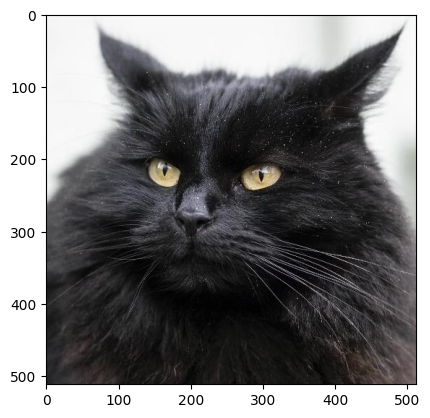

In [133]:
predict_by_path('/content/drive/MyDrive/afhq/val/cat/flickr_cat_000096.jpg')

Дикая


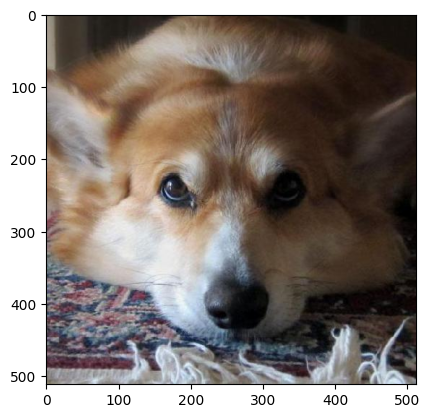

In [138]:
predict_by_path('/content/drive/MyDrive/afhq/val/dog/flickr_dog_000217.jpg')

Собака


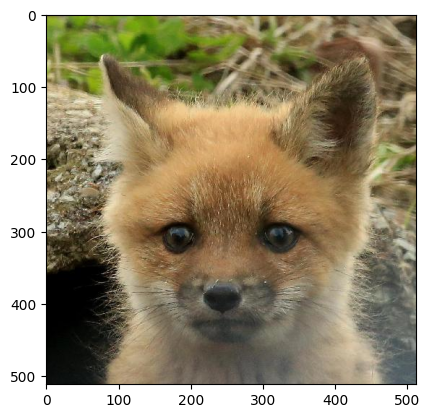

In [139]:
predict_by_path('/content/drive/MyDrive/afhq/val/wild/flickr_wild_000012.jpg')

# Изменения для вычисления средних и дисперсий по выборке обучающего датасета

In [151]:
# Вычисление средних и дисперсий
mean = torch.zeros(3)
std = torch.zeros(3)
count = 0

for data, _ in train_dataloader:
    data = data.to(device)
    batch_count = data.size(0)
    mean += data.mean((0, 2, 3)) * batch_count
    std += data.std((0, 2, 3)) * batch_count
    count += batch_count

mean /= count
std /= count

# Применение средних и дисперсий для нормализации
my_transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(p=0.5)
])

my_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(32),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])


# Изменения для добавления аугментаций с использованием Albumentations

In [152]:
import albumentations as A

# Albumentations для обучающего датасета
albumentations_transform = A.Compose([
    A.RandomContrast(limit=0.2, p=0.5),
    A.Blur(blur_limit=3, p=0.5),
    # Другие аугментации, если необходимо
])

# Обновление my_transform_train
my_transform_train.transforms.insert(3, transforms.Lambda(lambda x: albumentations_transform(image=x.numpy())))


# Изменения для дообучения предобученной сети VGG16

In [153]:
# Заменить MyCNN на VGG16 и заморозить первые слои
model = vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Заменить последний линейный слой
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 3)  # 3 - количество классов

# Перемещение модели на устройство
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Проверка модели после внесенных изменений

In [159]:
# Замена MyCNN на VGG16 и заморозка первых слоев
model = vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 3)  # 3 - количество классов

model = model.to(device)
model.eval()

def predict_by_path_vgg(path):
    image = Image.open(path)
    image_np = np.array(image)
    transformed_image = my_transform_test(image_np).to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(transformed_image)

    predicted_class = torch.argmax(output).item()
    class_name = dict_names[predicted_class]

    plt.imshow(image)
    print(f'Predicted class: {class_name}')

Predicted class: Кошка


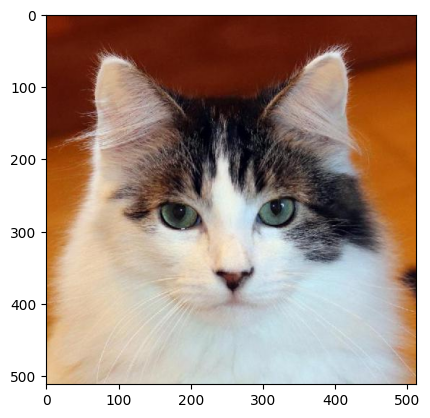

In [173]:
# Пример использования
predict_by_path_vgg('/content/drive/MyDrive/afhq/val/cat/flickr_cat_000008.jpg')


Predicted class: Собака


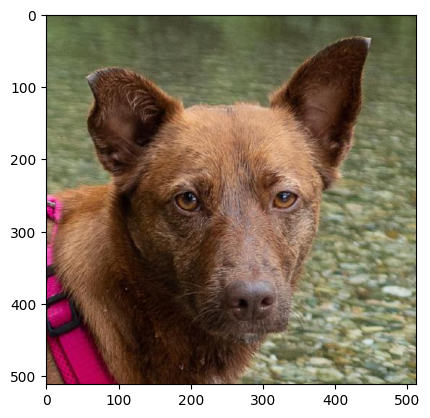

In [174]:
predict_by_path_vgg('/content/drive/MyDrive/afhq/val/dog/flickr_dog_000043.jpg')

Predicted class: Кошка


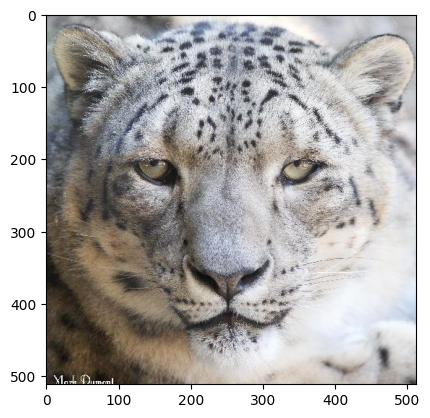

In [181]:

predict_by_path_vgg('/content/drive/MyDrive/afhq/val/wild/flickr_wild_000409.jpg')